In [1]:
from numba import cuda, jit
import numpy as np
import dataReader
from similarityMatrix import *
import math

## __Các bước thực hiện song song hóa Neighbor-based Collaborative Filtering__

+ __Bước 1__ Tính giá trị trung bình, giá trị Norm cho từng User
+ __Bước 2__ Xây dựng Similarity Matrix
+ __Bước 3__ Dự đoán các rating
+ __Bước 4__ Tính điểm RMSE để xem xét mức chênh lệch giữa tập test và tập predict

### __Hàm kernel tính trung bình và norm__

__Đầu vào__:
+ R: utility matrix được trải dài theo major-columns (với Utility matrix gốc là n_user*n_item)
+ cols: n_users
+ rows: n_items

__Đầu ra__:
+ avg: Giá trị trung bình của tất cả các rate tồn tại của mỗi user
+ norm: Giá trị được chuẩn hóa của mỗi user. Giá trị được chuẩn hóa cho bước Cosine Similarity.

In [2]:
@cuda.jit
def kernel_get_average_and_norm(R, cols, rows, avg, norm):
    bix = cuda.blockIdx.x
    bdx = cuda.blockDim.x
    tix = cuda.threadIdx.x


    tid = bix * bdx + tix
    if tid < cols:
        countNonZero = 0
        sum = 0
        avgThread = 0
        
        # With per items: 
        for i in range(rows):
            # Which item is rated by "tid" user
            if R[i*cols + tid] > 0:
                sum += R[i*cols + tid]
                countNonZero += 1
            
        if countNonZero > 0:
            avgThread = sum / countNonZero
        else:
            avgThread = 0
        
        if (tid < cols):
            avg[tid] = avgThread

        sum = 0
        for i in range(rows):
            if (R[i*cols + tid] > 0):
                sum += (R[i*cols + tid] - avgThread)**2
        
        if (tid < cols):
            norm[tid] = sum

### __Xây dựng Similarity matrix__

__Đầu vào__: R, cols, rows, avg, norm

__Đầu ra__: S (similarity_matrix với size là n_user*n_user)

#### Hàm __Cosine Similarity__

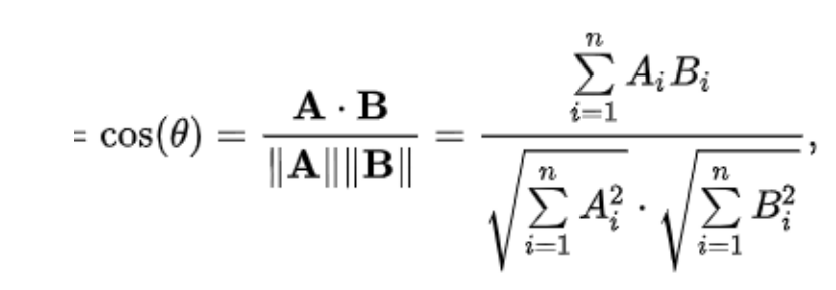

#### Tính Similarity cho từng user.

+ Kết quả cơ bản của ma trận similarity là một ma trận vuông n*n, với n là n_user/n_item tùy thuộc vào trường được chọn để tính.
+ Một user sẽ được tính độ tương đồng với tất cả những user còn lại dựa trên phương pháp Cosine Similarity bằng các item mà họ đã rated cùng nhau.
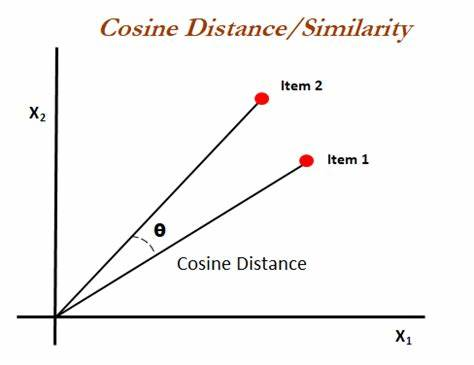

Cứ tưởng tượng rằng, mỗi một user sẽ có một vector item, để tạo ra similarity matrix, ta đi tìm độ đo Cosine Similarity cho từng cặp user

In [3]:
@cuda.jit
def kernel_build_similarity_matrix_cosine_similarity(R, cols, rows, avg, norm, S):
    # cols: n_users, rows: n_items
    bix = cuda.blockIdx.x
    bdx = cuda.blockDim.x
    tix = cuda.threadIdx.x

    # thread ID -> user index
    tid = bix * bdx + tix
    S[tid*cols + tid] = 1
    if tid < cols:
        for i in range(tid+1, cols):
            sum = 0
            for j in range(rows):
                if (R[j*cols + tid] > 0 and R[j*cols + i] > 0):
                    sum += (R[j*cols + tid] - avg[tid]) * (R[j*cols + i] - avg[i])
            S[tid*cols + i] = sum / (math.sqrt(norm[tid]) * math.sqrt(norm[i]))
            S[i*cols + tid] = S[tid*cols + i]

### __Xây dựng hàm predict kernel__

__Đầu vào__: R, cols, rows, avg, norm, S

__Đầu ra__: P (predicted matrix với size là n_item*n_user)

$$
    \hat{y}_{i, u} = \frac{\sum{u_j\in\N(u,i)}\bar{y}_{i,u_i} \cdot sim(u,u_j)}{\sum{u_j\in\N(u,i)} \cdot |sim(u,u_j)|}
$$

In [4]:
@cuda.jit
def kernel_predict(R, cols, rows, avg, norm, S, P):
    # cols: n_users, rows: n_items
    bix = cuda.blockIdx.x
    bdx = cuda.blockDim.x
    tix = cuda.threadIdx.x

    # thread ID -> user index
    # tid < cols
    tid = bix * bdx + tix
    if tid < cols:
        for i in range(rows):
            sum = 0
            sum_similarity = 0
            for j in range(cols):
                if (R[i*cols + j] > 0):
                    sum += S[tid*cols + j] * (R[i*cols + j] - avg[j])
                    sum_similarity += abs(S[tid*cols + j])
            if sum_similarity > 0:
                P[i*cols + tid] = avg[tid] + sum / sum_similarity
            else:
                P[i*cols + tid] = 0

In [5]:
@cuda.jit
def kernel_predict_with_bias(R, cols, rows, avg, norm, S, P, B):
    # cols: n_users, rows: n_items
    bix = cuda.blockIdx.x
    bdx = cuda.blockDim.x
    tix = cuda.threadIdx.x

    # thread ID -> user index
    tid = bix * bdx + tix
    if tid < cols:
        for i in range(cols):
            sum = 0
            for j in range(cols):
                if (R[tid*cols + j] > 0):
                    sum += S[i*cols + j] * (R[tid*cols + j] - avg[j] - B[j])
            P[tid*cols + i] = avg[i] + sum / norm[i]

In [6]:
data = dataReader.DataReader('../../data/ml-100k/ua.base').readTXT()
test = dataReader.DataReader('../../data/ml-100k/ua.test').readTXT()
utility_matrix = get_utility_matrix(data)

# Step 1: Calculate the mean matrix by kernel 
start_time = get_time()
n_users = utility_matrix.shape[0]
n_items = utility_matrix.shape[1]
R = utility_matrix.flatten('F')

avg = np.zeros(n_users)
norm = np.zeros(n_users)

d_avg = cuda.to_device(avg)
d_norm = cuda.to_device(norm)
d_R = cuda.to_device(R)

block_size = 256
grid_size = (n_users + block_size - 1) // block_size
kernel_get_average_and_norm[grid_size, block_size](d_R, n_users, n_items, d_avg, d_norm)
end_time = get_time()
print("Time to calculate the mean matrix: ", end_time - start_time)
avg = d_avg.copy_to_host()
norm = d_norm.copy_to_host()

# Step 2: Calculate the similarity matrix by kernel
start_time = get_time()
S = np.zeros(n_users*n_users)
d_S = cuda.to_device(S)
block_size = 256
grid_size = (n_users + block_size - 1) // block_size
kernel_build_similarity_matrix_cosine_similarity[grid_size, block_size](R, n_users, n_items, avg, norm, d_S)
end_time = get_time()
print("Time to calculate the similarity matrix: ", end_time - start_time)
S = d_S.copy_to_host()

# Step 3: Predict the utility matrix by kernel
start_time = get_time()
P = np.zeros(n_users*n_items)
d_P = cuda.to_device(P)
block_size = 256
grid_size = (n_items + block_size - 1) // block_size
kernel_predict[grid_size, block_size](R, n_users, n_items, avg, norm, d_S, d_P)
end_time = get_time()

print("Time to predict the utility matrix: ", end_time - start_time)
P = d_P.copy_to_host()
print(P.shape)


similarity_matrix = S.reshape(n_users, n_users)
print(similarity_matrix.shape)
print(avg.shape)
# print(S.shape)
np.savetxt('out/avg_kernel.csv', avg, delimiter=',')
np.savetxt('out/norm_kernel.csv', norm, delimiter=',')
np.savetxt('out/similarity_kernel.csv', similarity_matrix, delimiter=',')
np.savetxt('out/prediction_kernel.csv', P.reshape(n_users, n_items), delimiter=',')
print("Done!")

c:\Users\PC\anaconda3\envs\DSAIenv\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Time to calculate the mean matrix:  0:00:01.018936


c:\Users\PC\anaconda3\envs\DSAIenv\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\PC\anaconda3\envs\DSAIenv\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time to calculate the similarity matrix:  0:00:01.100069


c:\Users\PC\anaconda3\envs\DSAIenv\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\PC\anaconda3\envs\DSAIenv\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time to predict the utility matrix:  0:00:00.454005
(1586126,)
(943, 943)
(943,)
Done!


In [7]:
predict = P.reshape(n_items, n_users)
predict = predict.T

In [8]:
predict.shape

(943, 1682)

In [9]:
def recommend(utility_matrix, predict, user):
    # return the ratings of the user and the items that the user has not rated, don't need sort

    # get the ratings of the user
    ratings = utility_matrix[user]

    # get the items that the user has not rated
    not_rated_items = np.where(ratings == 0)[0]

    # get the ratings of the items that the user has not rated
    predict_ratings = predict[user]

    # get the ratings of the items that the user has not rated
    predict_ratings = predict_ratings[not_rated_items]

    # get the index of the items that the user has not rated
    items = np.arange(0, utility_matrix.shape[1])

    # get the index of the items that the user has not rated
    items = items[not_rated_items]
    
    return items, predict_ratings

In [10]:
def recommend_all(utility_matrix, predict):
    # return the matrix with 3 column: user, item, predict_rating  
    result = []
    for i in range(utility_matrix.shape[0]):
        items, ratings = recommend(utility_matrix, predict, i)
        for j in range(len(items)):
            result.append([i, items[j], ratings[j]])
    return np.array(result)

In [11]:
result = recommend_all(utility_matrix, predict)

In [37]:
def get_item_from_test(test, user):
    return test[np.where(test[:, 0] == user)]

In [39]:
get_item_from_test(test, 0).T[1]

array([ 19,  32,  60, 116, 154, 159, 170, 188, 201, 264])

In [61]:
user = 2
predict[user, list(get_item_from_test(test, user).T[1])].reshape(10,1)

array([[2.63341284],
       [2.8044838 ],
       [2.80152989],
       [2.88960319],
       [2.68179717],
       [2.72310571],
       [3.04639862],
       [2.80276929],
       [2.53936788],
       [2.64987364]])

In [62]:
test[user*10:(user+1)*10]

array([[  2, 244,   1],
       [  2, 293,   2],
       [  2, 322,   2],
       [  2, 327,   5],
       [  2, 330,   4],
       [  2, 331,   1],
       [  2, 333,   3],
       [  2, 334,   1],
       [  2, 336,   1],
       [  2, 342,   3]])

In [54]:
result

array([[   0.        ,   19.        ,    3.54311551],
       [   0.        ,   32.        ,    3.54907158],
       [   0.        ,   60.        ,    3.94647519],
       ...,
       [ 942.        , 1679.        ,    0.        ],
       [ 942.        , 1680.        ,    3.4037687 ],
       [ 942.        , 1681.        ,    3.01781223]])

In [55]:
test

array([[   0,   19,    4],
       [   0,   32,    4],
       [   0,   60,    4],
       ...,
       [ 942,  569,    1],
       [ 942,  807,    4],
       [ 942, 1066,    2]])

In [56]:
result.shape

(1495556, 3)

In [57]:
# find score of the recommendation with test data by RMSE
def RMSE(test, predict):
    sum = 0
    for i in range(test.shape[0]):
        user = test[i][0]
        item = test[i][1]
        rating = test[i][2]

        sum += (predict[user, item] - rating)**2
    return math.sqrt(sum/test.shape[0])

In [58]:
RMSE(test, predict)

0.9641134758958154